# American Electric Power Energy Comsumption Forecasting Using Classical Time-series Forecasting

In [1]:
# The code below ignores warnings generated from certain cells
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/AEP_hourly.csv', parse_dates=['Datetime'])

In [5]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [6]:
#Data Overviews Function
def sum_info(df):
    print("Number of rows: {0}, number of columns: {1}".format(df.shape[0], df.shape[1]))
    info = pd.DataFrame(df.dtypes, columns=['dtypes'])
    info = info.reset_index()
    info['Name'] = info['index']
    info = info[['Name', 'dtypes']]
    info['Missing'] = df.isnull().sum().values
    info['Missing_%'] = info['Missing']/df.shape[0]*100
    info['Uniques'] = df.nunique().values
    info['First Row'] = df.loc[0].values
    info['Last Row'] = df.loc[df.shape[0]-1].values

    return info

In [7]:
sum_info(df)

Number of rows: 121273, number of columns: 2


,Name,dtypes,Missing,Missing_%,Uniques,First Row,Last Row
0,Datetime,datetime64[ns],0,0.0,121269,2004-12-31 01:00:00,2018-01-02 00:00:00
1,AEP_MW,float64,0,0.0,12643,13478.0,19993.0


In [8]:
print(df['Datetime'].min())
print(df['Datetime'].max())

2004-10-01 01:00:00
2018-08-03 00:00:00


In [9]:
print(df['AEP_MW'].min())
print(df['AEP_MW'].max())

9581.0
25695.0


In [10]:
df = df.sort_values(by='Datetime').reset_index(drop=True)

In [11]:
df.head()

,Datetime,AEP_MW
0,2004-10-01 01:00:00,12379.0
1,2004-10-01 02:00:00,11935.0
2,2004-10-01 03:00:00,11692.0
3,2004-10-01 04:00:00,11597.0
4,2004-10-01 05:00:00,11681.0


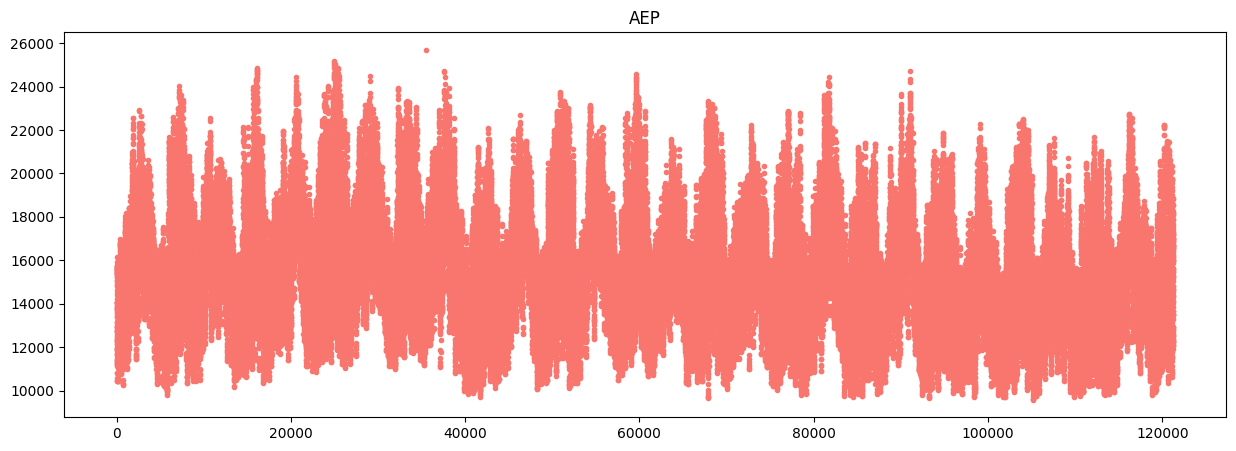

In [12]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
df['AEP_MW'].plot(style='.', figsize=(15,5), color=color_pal[0], title='AEP')
plt.savefig("AEP.png", dpi=300)
plt.show()


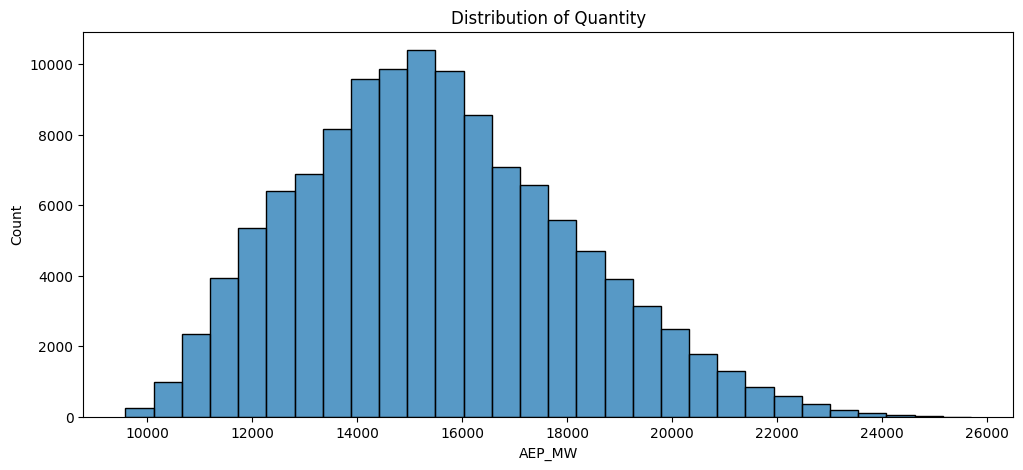

In [13]:
plt.figure(figsize=(12, 5))
sns.histplot(data=df, x='AEP_MW', bins=30)
ax = plt.gca()
ax.set_title('Distribution of Quantity')
ax.grid(False)
plt.savefig("AEP_Histogram.png", dpi=300)
plt.show()

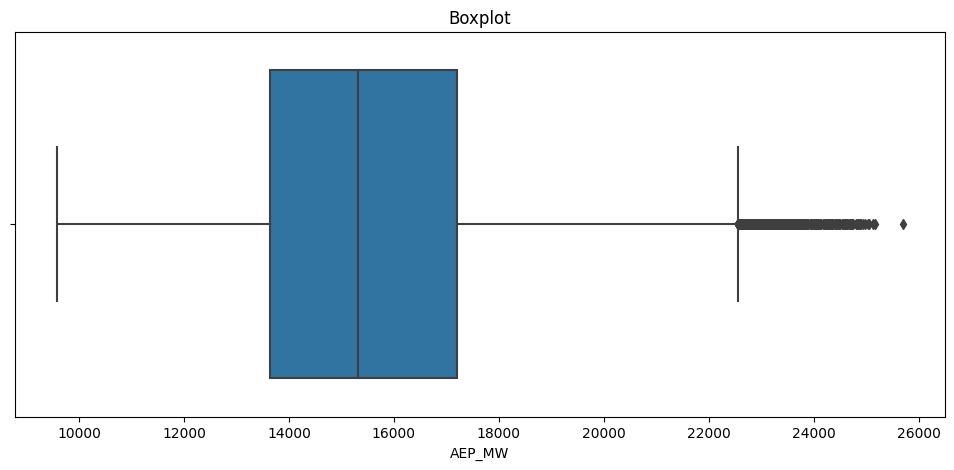

In [14]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x='AEP_MW', orient='h')
ax = plt.gca()
ax.set_title('Boxplot')
ax.grid(False)
plt.savefig("AEP_boxplot.png", dpi=300)
plt.show()

## Features Engineering

In [15]:
data = df.copy()
date_ini = '2005-01-01'
date_fin = '2018-01-01'
date_max = '2018-07-03'
data_train = data[(data['Datetime']>=date_ini) & (data['Datetime']<date_fin)]
data_test = data[(data['Datetime']>=date_fin) & (data['Datetime']<date_max)]
data_train = data_train.sort_values(by='Datetime').reset_index(drop=True)
data_test = data_test.sort_values(by='Datetime').reset_index(drop=True)

In [16]:
data_train.head()

,Datetime,AEP_MW
0,2005-01-01 00:00:00,12892.0
1,2005-01-01 01:00:00,12316.0
2,2005-01-01 02:00:00,11890.0
3,2005-01-01 03:00:00,11579.0
4,2005-01-01 04:00:00,11461.0


In [17]:
data_train.tail()

,Datetime,AEP_MW
113926,2017-12-31 19:00:00,19608.0
113927,2017-12-31 20:00:00,19442.0
113928,2017-12-31 21:00:00,19323.0
113929,2017-12-31 22:00:00,19092.0
113930,2017-12-31 23:00:00,18877.0


In [18]:
data_test.head()

,Datetime,AEP_MW
0,2018-01-01 00:00:00,18687.0
1,2018-01-01 01:00:00,18508.0
2,2018-01-01 02:00:00,18600.0
3,2018-01-01 03:00:00,18571.0
4,2018-01-01 04:00:00,18686.0


In [19]:
data_test.tail()

,Datetime,AEP_MW
4386,2018-07-02 19:00:00,19864.0
4387,2018-07-02 20:00:00,19401.0
4388,2018-07-02 21:00:00,18774.0
4389,2018-07-02 22:00:00,18315.0
4390,2018-07-02 23:00:00,17251.0


In [20]:
#resampling data data
data_test.set_index('Datetime', inplace=True)
data_train.set_index('Datetime', inplace=True)

monthly_test = data_test.resample('M').sum()
monthly_train = data_train.resample('M').sum()

In [21]:
monthly_test.tail()

,AEP_MW
Datetime,
2018-03-31,11228646.0
2018-04-30,9820256.0
2018-05-31,10503052.0
2018-06-30,11019780.0
2018-07-31,823240.0


In [22]:
monthly_test = monthly_test.drop(labels='2018-07-31')

In [23]:
monthly_test.count()

AEP_MW    6
dtype: int64

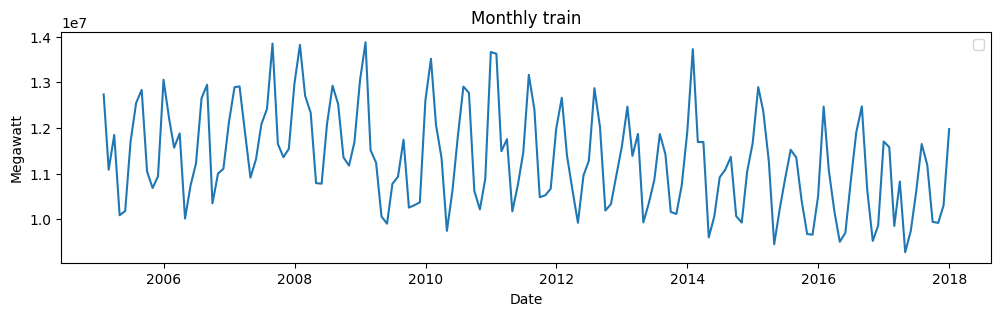

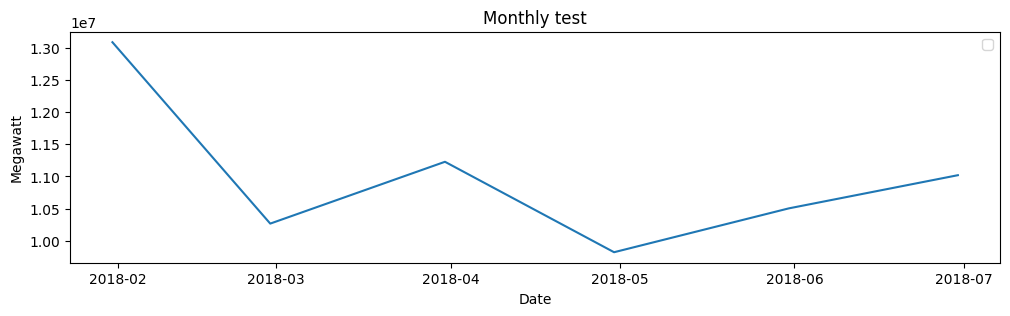

In [24]:
# Plot daily data train

plt.figure(figsize=(12, 3))
plt.plot(monthly_train.index, monthly_train['AEP_MW'])
plt.title('Monthly train')
plt.xlabel('Date')
plt.ylabel('Megawatt')
plt.legend()
plt.savefig("AEP_monthly-train.png", dpi=300)
plt.show()

# Plot daily data test
plt.figure(figsize=(12, 3))
plt.plot(monthly_test.index, monthly_test['AEP_MW'])
plt.title('Monthly test')
plt.xlabel('Date')
plt.ylabel('Megawatt')
plt.legend()
plt.savefig("AEP_monthly-test.png", dpi=300)
plt.show()

In [25]:
decomposition = seasonal_decompose(monthly_train, model='additive')

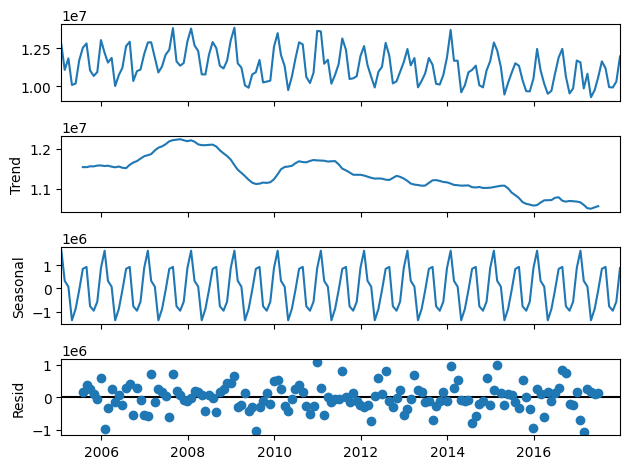

In [26]:
decomposition.plot();
plt.savefig("AEP_decomposition.png", dpi=300)

## ADF Testing

In [27]:
result = adfuller(monthly_train)
print('p-value: %f' % result[1])

result = adfuller(monthly_train.diff(3).dropna())
print('p-value: %f' % result[1])


p-value: 0.522386
p-value: 0.000000


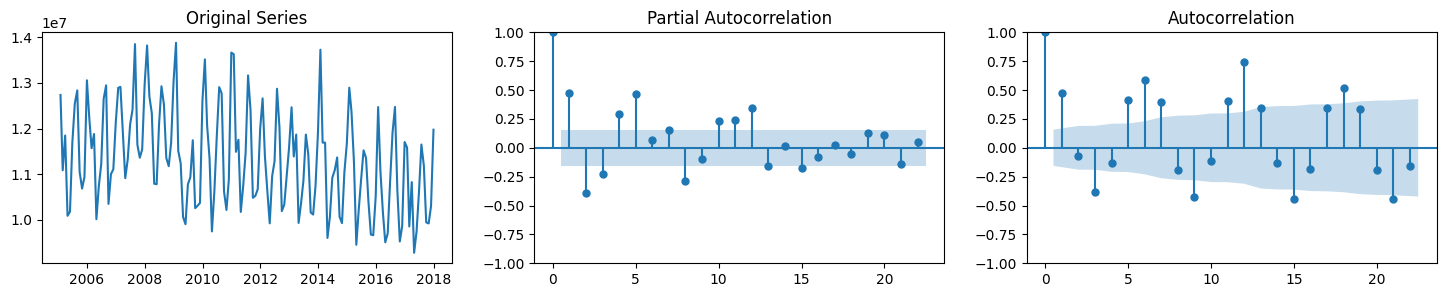

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18,3))

axes[0].plot(monthly_train)
axes[0].set_title('Original Series')
plot_pacf(monthly_train, ax=axes[1]);
plot_acf(monthly_train, ax=axes[2]);
plt.savefig("AEP_AutoCorrelation.png", dpi=300)

In [29]:
result = kpss(monthly_train['AEP_MW'])
print(f"KPSS Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# Assuming a significance level of 0.05
if result[1] > 0.05:
    print("The data is likely trend stationary.")
else:
    print("The data appears to be non-stationary.")

KPSS Statistic: 1.0628473729471115
p-value: 0.01
The data appears to be non-stationary.


/tmp/ipykernel_18/545584341.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(monthly_train['AEP_MW'])


# Classical Time-series Forecasting

## Simple Moving Average

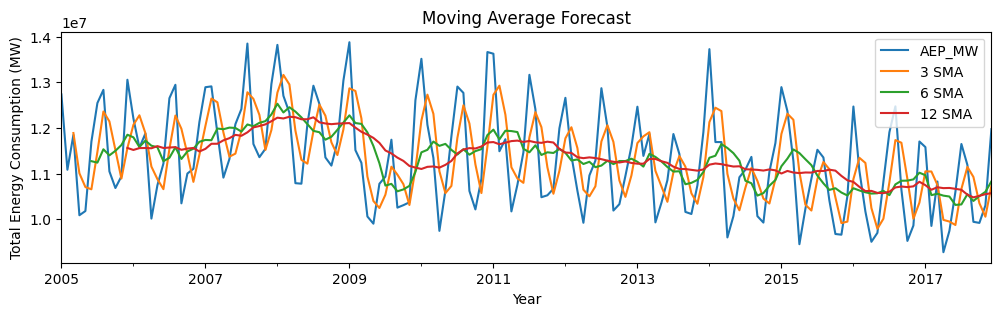

In [30]:
# Simple Moving average
monthly_train['3 SMA'] = monthly_train['AEP_MW'].rolling(window = 3).mean()
monthly_train['6 SMA'] = monthly_train['AEP_MW'].rolling(window = 6).mean()
monthly_train['12 SMA'] = monthly_train['AEP_MW'].rolling(window = 12).mean()

# Plot the data and moving average
monthly_train[['AEP_MW', '3 SMA', '6 SMA', '12 SMA']].plot(kind='line', figsize=(12, 3))
plt.title("Moving Average Forecast")
plt.xlabel("Year")
plt.ylabel("Total Energy Consumption (MW)")
plt.savefig("AEP_SMA.png", dpi=300)
plt.show()

## Simple Exponentials Smoothing

/opt/conda/lib/python3.10/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


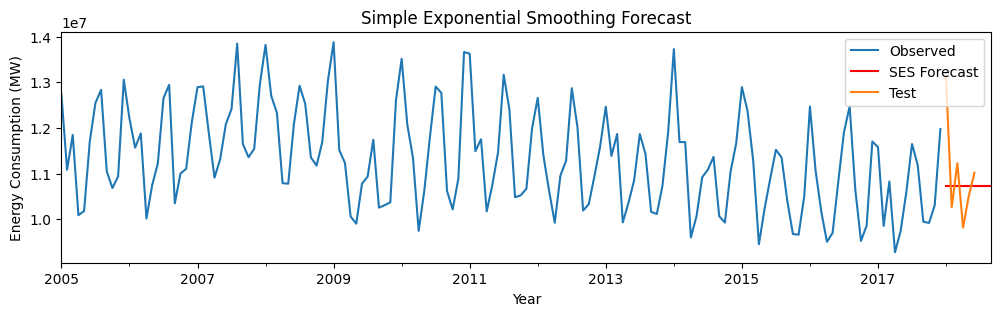

In [31]:
# Simple Exponential Smoothing
SES = SimpleExpSmoothing(monthly_train['AEP_MW'])
SES_fit = SES.fit(smoothing_level=0.2)
SES_forecast = SES_fit.forecast(len(monthly_test)+3)

# Plot the data and forecast
monthly_train['AEP_MW'].plot(label = 'Observed',figsize=(12, 3))
SES_forecast.plot(label = 'SES Forecast', color = 'red', figsize=(12, 3))
monthly_test['AEP_MW'].plot(label = 'Test', figsize=(12, 3))
plt.legend()
plt.title("Simple Exponential Smoothing Forecast")
plt.xlabel("Year")
plt.ylabel("Energy Consumption (MW)")
#plt.xlim('2017-05-01', '2018-08-02')
plt.savefig("AEP_SES.png", dpi=300)
plt.show()

## Holt’s Linear Trend Model

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


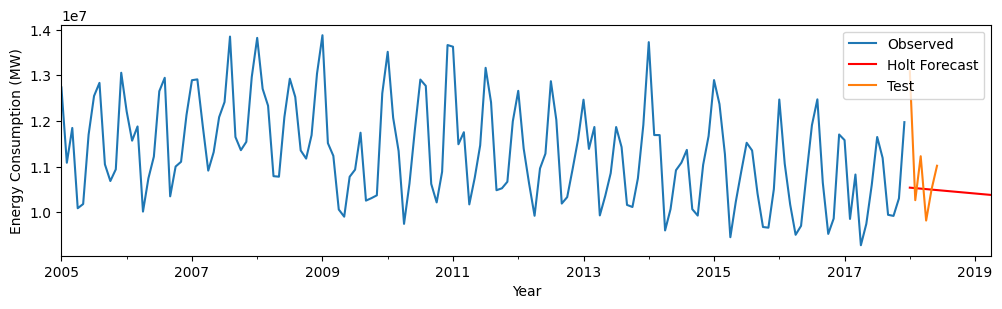

In [32]:
# Holt's Linear Trend Model
HWL = ExponentialSmoothing(monthly_train['AEP_MW'], trend='add', seasonal=None)
HWL_fit = HWL.fit()
HWL_forecast = HWL_fit.forecast(len(monthly_test)+10)

# Plot the data and forecast
monthly_train['AEP_MW'].plot(label = 'Observed',  figsize=(12, 3))
HWL_forecast.plot(label = 'Holt Forecast', color = 'red')
monthly_test['AEP_MW'].plot(label = 'Test', figsize=(12, 3))
plt.legend()
plt.xlabel("Year")
plt.ylabel("Energy Consumption (MW)")
#plt.xlim('2017-05-01', '2018-08-02')
plt.savefig("AEP_HWL.png", dpi=300)
plt.show()

## Holt-Winters Seasonal Model

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


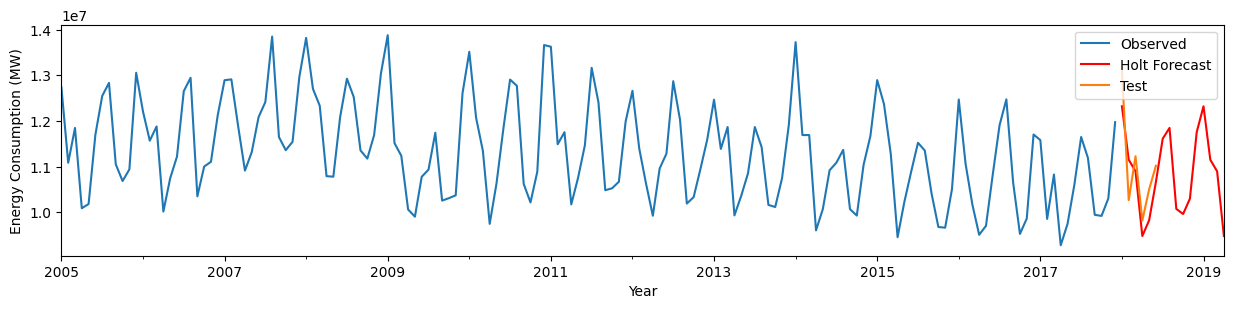

In [33]:
HWS = ExponentialSmoothing(monthly_train['AEP_MW'], seasonal = 'add', seasonal_periods = 12)
HWS_fit = HWS.fit()
HWS_forecast = HWS_fit.forecast(len(monthly_test)+10)

# Plot the data and forecast
plt.figure(figsize=(15,3))
monthly_train['AEP_MW'].plot(label = 'Observed')
HWS_forecast.plot(label = 'Holt Forecast', color = 'red')
monthly_test['AEP_MW'].plot(label = 'Test')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Energy Consumption (MW)")
#plt.xlim('2017-05-01', '2018-08-02')
plt.savefig("AEP_HWS.png", dpi=300)
plt.show()

## ARIMA

Finding p,d,q?

In [34]:
monthly_train = monthly_train.drop(columns=['3 SMA', '6 SMA', '12 SMA'])

In [35]:
monthly_train.head()

,AEP_MW
Datetime,
2005-01-31,12735114.0
2005-02-28,11085745.0
2005-03-31,11847502.0
2005-04-30,10089312.0
2005-05-31,10181694.0


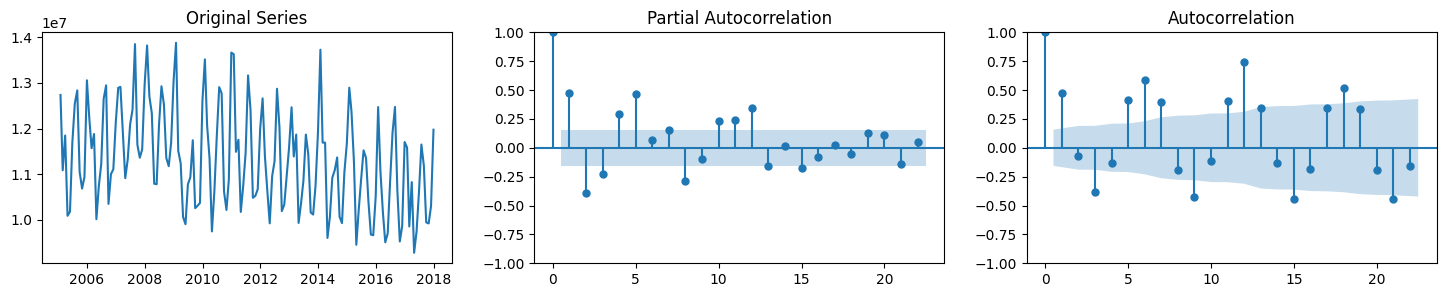

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18,3))

axes[0].plot(monthly_train)
axes[0].set_title('Original Series')
plot_pacf(monthly_train, ax=axes[1]);
plot_acf(monthly_train, ax=axes[2]);

p = 1 or 5 <br>
d = 1 <br>
q = 1 or 6


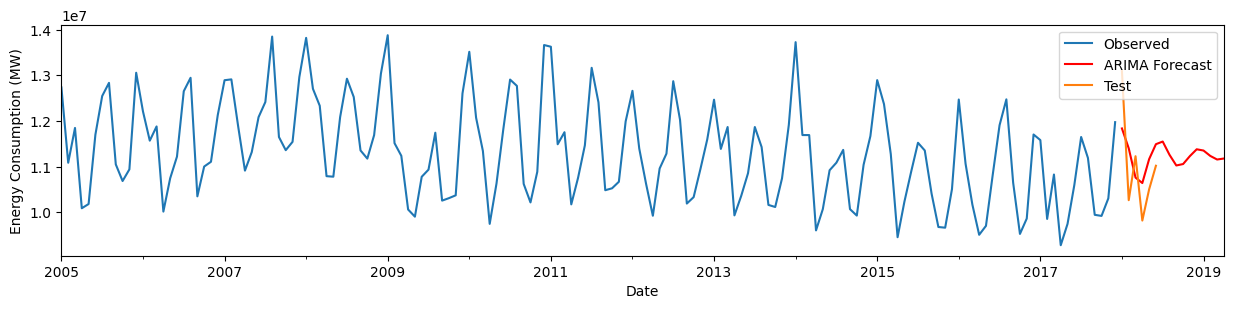

In [37]:
# Fit ARIMA model
ARIMA_mod = ARIMA(monthly_train['AEP_MW'], order = (5, 1, 1))
ARIMA_fit = ARIMA_mod.fit()

# Forecast
ARIMA_forecast = ARIMA_fit.forecast(len(monthly_test)+10)

# Plot the data and forecast
plt.figure(figsize=(15,3))
monthly_train['AEP_MW'].plot(label = 'Observed')
ARIMA_forecast.plot(label = 'ARIMA Forecast', color = 'red')
monthly_test['AEP_MW'].plot(label = 'Test')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Energy Consumption (MW)")
#plt.xlim('2017-05-01', '2018-08-02')
plt.savefig("AEP_ARIMA.png", dpi=300)
plt.show()

In [38]:
pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [39]:
from pmdarima import auto_arima

In [40]:
model_arima = auto_arima(monthly_train, trace=True)  # Set trace=True for detailed output (optional)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4759.467, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4761.144, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4761.053, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4757.473, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4741.316, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4735.729, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4760.279, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4700.665, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4718.605, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4697.544, Time=0.33 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4695.847, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4698.625, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4698.341, Time=0.52 sec
 ARIMA(4,1,0)(0,0,0)[0]             : 

In [41]:
print(model_arima.summary())  # Print model summary
print(model_arima.order)  # Print ARIMA order (p, d, q)
print(model_arima.seasonal_order)  # Print seasonal ARIMA order (P, D, Q, s) if applicable

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(4, 1, 0)   Log Likelihood               -2341.895
Date:                Wed, 17 Jul 2024   AIC                           4693.790
Time:                        03:43:52   BIC                           4709.007
Sample:                    01-31-2005   HQIC                          4699.971
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3439      0.049     -7.088      0.000      -0.439      -0.249
ar.L2         -0.2287      0.035     -6.568      0.000      -0.297      -0.160
ar.L3         -0.4513      0.022    -20.596      0.0

In [42]:
# Predict the next 5 values
predict_arima = model_arima.predict(n_periods=5)
print(predict_arima)

2018-01-31    1.173992e+07
2018-02-28    1.127351e+07
2018-03-31    1.060590e+07
2018-04-30    1.048961e+07
2018-05-31    1.097126e+07
Freq: ME, dtype: float64


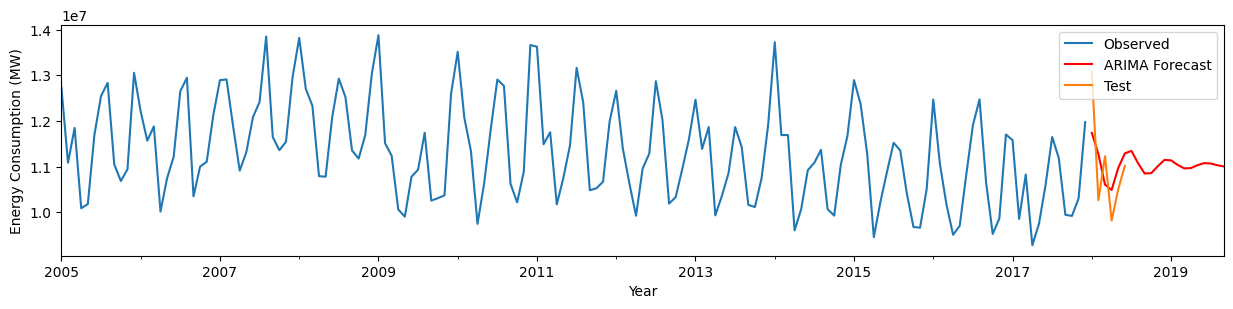

In [43]:
# Fit ARIMA model
ARIMA_mod = ARIMA(monthly_train['AEP_MW'], order = (4, 1, 0))
ARIMA_fit = ARIMA_mod.fit()

# Forecast
ARIMA_forecast = ARIMA_fit.forecast(len(monthly_test)+15)

# Plot the data and forecast
plt.figure(figsize=(15,3))
monthly_train['AEP_MW'].plot(label = 'Observed')
ARIMA_forecast.plot(label = 'ARIMA Forecast', color = 'red')
monthly_test['AEP_MW'].plot(label = 'Test')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Energy Consumption (MW)")
#plt.xlim('2017-05-01', '2018-08-02')
plt.savefig("AEP_AutoArima.png", dpi=300)
plt.show()

## SARIMAX

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52003D+01    |proj g|=  4.05626D-01

At iterate    5    f=  1.50122D+01    |proj g|=  1.32507D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   1.995D-05   1.501D+01
  F =   15.012147106680091     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


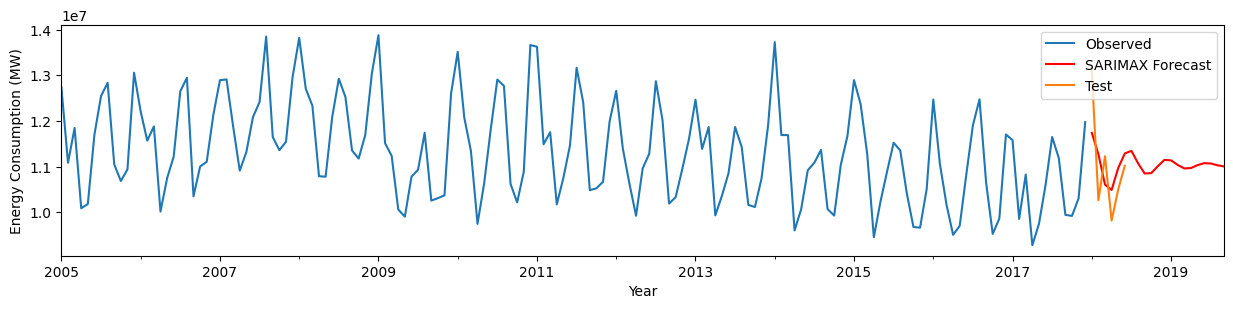

In [44]:
# Fit SARIMA model
SARIMAX_mod = SARIMAX(monthly_train['AEP_MW'], order = (4, 1, 0), seasonal_order=(0, 0, 0, 0))
SARIMAX_fit = SARIMAX_mod.fit()

# Forecast
SARIMAX_forecast = SARIMAX_fit.get_forecast(len(monthly_test)+15).predicted_mean

# Plot the data and forecast
plt.figure(figsize=(15,3))
monthly_train['AEP_MW'].plot(label = 'Observed')
SARIMAX_forecast.plot(label = 'SARIMAX Forecast', color = 'red')
monthly_test['AEP_MW'].plot(label = 'Test')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Energy Consumption (MW)")
#plt.xlim('2017-05-01', '2018-08-02')
plt.savefig("AEP_Sarimax.png", dpi=300)
plt.show()